In [1]:
from fenics import *
import numpy
import matplotlib.pyplot as plt

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math -march=native'
parameters["form_compiler"]["representation"] = "uflacs"
%matplotlib inline

The periodic domain is denoted by $\Omega$, its period is denoted by $\epsilon$. The rescaled unit periodic cell is denoted by $Y = (0, 1)^N$.

The conductivity tensor in $\Omega$ is $A \left( \frac{x}{\epsilon} \right)$, where $A(y)$ is $Y$-periodic.

Denoting by $f(x)$ the source term, and enforcing a Dirichlet boundary condition, our model problem reads

\begin{cases}
-\mbox{div} \left( A \left( \frac{x}{\epsilon} \right) \nabla u_{\epsilon} \right) = f && in \, \Omega \\
u_{\epsilon} = 0 && on \, \partial \Omega
\end{cases}

To compute numerically the solution $u_{\epsilon}$ a mesh spacing $h$ that must be smaller than $\epsilon$. $\epsilon$ might too small resulting in requirement of really fine mesh. The better approach is to solve the homogenized problem corresponding to our model problem

\begin{cases}
-\mbox{div} \left( A^* \nabla u(x) \right) = f(x) && in \, \Omega \\
u = 0 && on \, \partial \Omega
\end{cases}

The homogenized tensor $A^*$ is constant, therefore there is no requirement for $h$ to be small.

We need to compute the $N$ cell solutions of the cell problems, for $1  \leq i \leq N$

\begin{cases}
-\nabla_y \cdot (A(y) \nabla_y w_i)  = \nabla_y \cdot (A(y) \cdot e_i) && in \, Y \\
y \rightarrow w_i(y) && Y periodic
\end{cases}

Then the value of the tensor $A^*$ is
$$ A^*_{ij} = \int_Y A(y) (e_i + \nabla_y w_i) \cdot e_j \, dy = \int_Y A(y) (e_i + \nabla_y w_i) \cdot (e_j + \nabla w_j) \, dy$$

In [36]:
e = 0.025
epsilon = Constant(e)
A = Expression('pow((2 + cos( (2 * pi * x[0]) / epsilon)), -1)', degree = 1, epsilon = epsilon)

# Create local cell
mesh = UnitSquareMesh(50, 50)

def create_periodic_boundary(e):
    # Sub domain for Periodic boundary condition
    class PeriodicBoundary(SubDomain):

        def inside(self, x, on_boundary):
            # return True if on left or bottom boundary AND NOT on one of the two corners (0, epsilon) and (epsilon, 0)
            return bool((near(x[0], 0) or near(x[1], 0)) and 
                  (not ((near(x[0], 0) and near(x[1], e)) or 
                        (near(x[0], e) and near(x[1], 0)))) and on_boundary)

        def map(self, x, y):
            if near(x[0], e) and near(x[1], e):
                y[0] = x[0] - e
                y[1] = x[1] - e
            elif near(x[0], e):
                y[0] = x[0] - e
                y[1] = x[1]
            else:   # near(x[1], e)
                y[0] = x[0]
                y[1] = x[1] - e

def solve_cell_problem(mesh, A, epsilon):
    epsilon.assign(1.0)
    p_bc = create_periodic_boundary(epsilon)

    V = FunctionSpace(mesh, 'P', 2, constrained_domain=p_bc)

    e0 = as_vector((1, 0))
    e1 = as_vector((0, 1))

    u = TrialFunction(V)
    v = TestFunction(V)

    Afunc = interpolate(A, V)

    #a = inner(Afunc*as_vector((0, u.dx(1))), as_vector((0, v.dx(1))))*dx
    a = inner(Afunc * u.dx(1), v.dx(1))*dx
    
    L1 = inner((Afunc*e0).dx(1), as_vector((v, v)))*dx
    L2 = inner((Afunc*e1).dx(1), as_vector((v, v)))*dx

    u0 = Function(V)
    u1 = Function(V)

    solve(a == L1, u0)
    solve(a == L2, u1)

    return u0, u1

def compute_effective_tensor(w0, w1, A, mesh):
    
    # Theory requires expression for A* to be integrated along a single dimension
    #1D integration domain
    m_1D = UnitIntervalMesh(100)
    V_1D = FunctionSpace(m_1D, 'P', 1)

    # An Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)
    class my1DExpression(Expression):
        def __init__(self, u_2d, x, **kwargs):
            self.u_2d = u_2d
            self.x = x
            self._vx = numpy.array([0.])
            self._pt_x = numpy.array([0.,0.])
        def eval(self, values, x):
            self._pt_x[0] = self.x
            self._pt_x[1] = x[0]
            self.u_2d.eval(self._vx,self._pt_x)
            values[0] = self._vx[0]

    #it is possible to define the u(x) function
    class UxExpression(Expression):
        def __init__(self, u_2d, **kwargs):
            self.u_2d = u_2d

        def eval(self, values, x):
            _Uy = interpolate(my1DExpression(self.u_2d, x = x[0], degree = 2), V_1D)
            values[0] = assemble(_Uy * dx)

    A_1D = interpolate(UxExpression(A, degree = 2), V_1D)
    w0_1D = interpolate(UxExpression(w0, degree = 2), V_1D)
    w1_1D = interpolate(UxExpression(w1, degree = 2), V_1D)
    
    e0 = as_vector((1, 0))
    e1 = as_vector((0, 1))

    A_00 = assemble(dot(A_1D*e0 + as_vector((0, A_1D*w0_1D.dx(0))), e0)*dx) # A_00
    A_10 = assemble(dot(A_1D*e1 + as_vector((0, A_1D*w1_1D.dx(0))), e0)*dx) # A_10
    A_01 = assemble(dot(A_1D*e0 + as_vector((0, A_1D*w0_1D.dx(0))), e1)*dx) # A_01
    A_11 = assemble(dot(A_1D*e1 + as_vector((0, A_1D*w1_1D.dx(0))), e1)*dx) # A_11

    return A_00, A_10, A_01, A_11

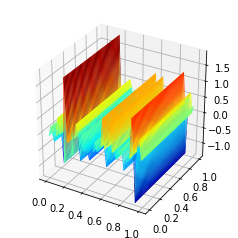

In [37]:
w0, w1 = solve_cell_problem(mesh, A, epsilon)
plot(w1, mode = 'warp')

In [38]:
A_00, A_10, A_01, A_11 = compute_effective_tensor(w0, w1, A, mesh)
print([A_00, A_10, A_01, A_11])

[0.5773502691896257, 0.0, 0.13216508428079993, 0.7095153534704262]


## Global problem

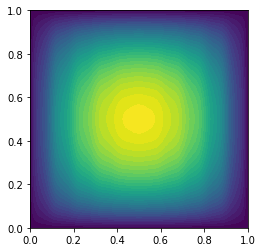

In [41]:
mesh = UnitSquareMesh(50, 50)

V = FunctionSpace(mesh, "Lagrange", 1)

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, "on_boundary")
C = as_matrix(((A_00, A_10), (A_01, A_11)))
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = 1.0

epsilon.assign(e)

a = inner(A*grad(u), grad(v))*dx # Change C to A for not homogenized problem
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)
plot(u)

In [42]:
u.vector().norm('l2')

3.7565343309542767

In [40]:
u.vector().norm('l2')

3.2105054128842254

L2 norm of homogenized solution 3.2105054128842254

L2 norm of normal solution 3.7565343309542767